In [13]:
# grader-required-cell

import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/learn-ai-bbc.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [15]:
df = pd.read_csv("/content/BBC News Train.csv")
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [16]:
dif = pd.read_csv("/content/BBC News Test.csv")
dif.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [17]:
df["Category"].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [19]:
import pandas as pd

def clean_dataframe(df):
    # Check and print the number of duplicate rows based on 'ArticleId' column
    duplicate_rows = df[df.duplicated(subset='ArticleId', keep='first')]
    print(f"Number of duplicate rows: {len(duplicate_rows)}")
    
    # Check and print the number of rows with empty values in 'Text' and 'Category' columns
    empty_text_rows = df[df['Text'].isnull() | df['Text'].str.strip().eq('')]
    empty_category_rows = df[df['Category'].isnull() | df['Category'].str.strip().eq('')]
    print(f"Number of rows with empty 'Text': {len(empty_text_rows)}")
    print(f"Number of rows with empty 'Category': {len(empty_category_rows)}")

    # Remove duplicates based on 'ArticleId' column
    df = df.drop_duplicates(subset='ArticleId', keep='first')

    # Remove rows with empty values in 'Text' and 'Category' columns
    df = df[df['Text'].notnull() & df['Text'].str.strip().ne('')]
    df = df[df['Category'].notnull() & df['Category'].str.strip().ne('')]

    return df

# Assuming your dataframe is already created and named 'df'
df_cleaned = clean_dataframe(df)


Number of duplicate rows: 0
Number of rows with empty 'Text': 0
Number of rows with empty 'Category': 0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


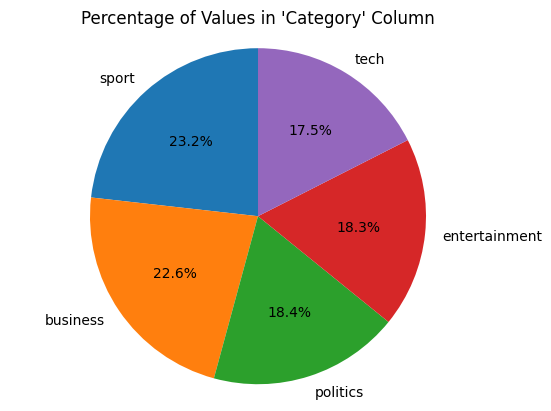

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is already created and named 'df'
category_counts = df["Category"].value_counts()

# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a title
plt.title("Percentage of Values in 'Category' Column")

# Show the pie chart
plt.show()


<ipython-input-22-918bfbd9b6ab>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis")


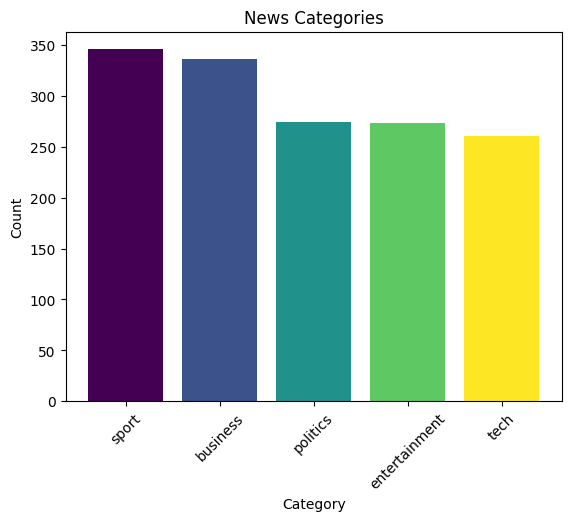

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataframe is already created and named 'df'
category_counts = df["Category"].value_counts()

# Plot the bar chart
fig, ax = plt.subplots()

# Create a colormap and generate a list of colors for the bars
cmap = plt.cm.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(category_counts)))

# Draw the bars with the specified colors
ax.bar(category_counts.index, category_counts, width=0.8, color=colors)

# Add labels and a title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title("News Categories")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()


In [30]:
# grader-required-cell

NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .9

In [27]:
# grader-required-cell

def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[2])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [26]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [29]:
# grader-required-cell

# Test the functions
sentences, labels = parse_data_from_file("/content/BBC News Train.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")
print(f"The first 2 sentences are {sentences[:2]}")

There are 1490 sentences in the dataset.

First sentence has 203 words (after removing stopwords).

There are 1490 labels in the dataset.

The first 5 labels are ['business', 'business', 'business', 'tech', 'business']
The first 2 sentences are ['worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness. cynthia cooper worldcom s ex-head internal accounting alerted directors irregular accounting practices us telecoms giant 2002. warnings led collapse firm following discovery $11bn (£5.7bn) accounting fraud. mr ebbers pleaded not guilty charges fraud conspiracy. prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates. ms cooper now runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom s accounting early 2001 2002. said andersen gi

In [31]:
# grader-required-cell

# GRADED FUNCTIONS: train_val_split
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """
    
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [32]:
# grader-required-cell

# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1341 sentences for training.

There are 1341 labels for training.

There are 149 sentences for validation.

There are 149 labels for validation.


In [33]:
# grader-required-cell

# GRADED FUNCTION: fit_tokenizer
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [34]:
# grader-required-cell

# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 23886 words

<OOV> token included in vocabulary


In [35]:
# grader-required-cell

# GRADED FUNCTION: seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """ 
    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    ### END CODE HERE
    
    return padded_sequences

In [39]:
# grader-required-cell

# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1341, 120)

Padded validation sequences have shape: (149, 120)


In [40]:
# grader-required-cell

# GRADED FUNCTION: tokenize_labels
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
    
    ### END CODE HERE
    
    return label_seq_np

In [41]:
# grader-required-cell

# Test your function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set should look like this:
[[1]
 [3]
 [0]
 [4]
 [4]]

Tokenized labels of the training set have shape: (1341, 1)

Tokenized labels of the validation set have shape: (149, 1)



In [42]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [44]:

model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=100, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/100
42/42 [==============================] - 1s 8ms/step - loss: 1.6024 - accuracy: 0.2334 - val_loss: 1.5980 - val_accuracy: 0.2215
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 1.5801 - accuracy: 0.2409 - val_loss: 1.5712 - val_accuracy: 0.2416
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 1.5369 - accuracy: 0.3915 - val_loss: 1.5218 - val_accuracy: 0.3490
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 1.4656 - accuracy: 0.5198 - val_loss: 1.4436 - val_accuracy: 0.4631
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 1.3595 - accuracy: 0.6070 - val_loss: 1.3300 - val_accuracy: 0.5906
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 1.2205 - accuracy: 0.6868 - val_loss: 1.1923 - val_accuracy: 0.6980
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 1.0554 - accuracy: 0.7435 - val_loss: 1.0307 - val_accuracy: 0.7315
Epoch 8/100
4

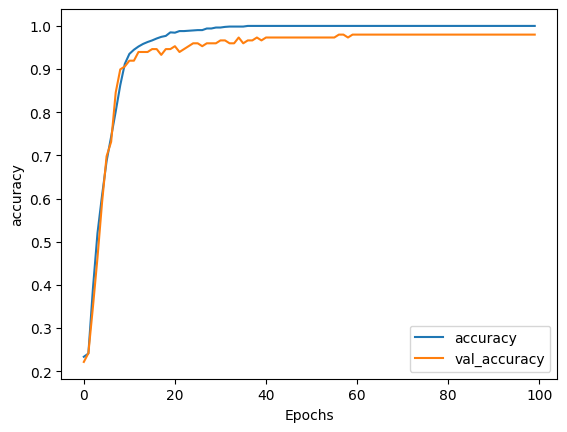

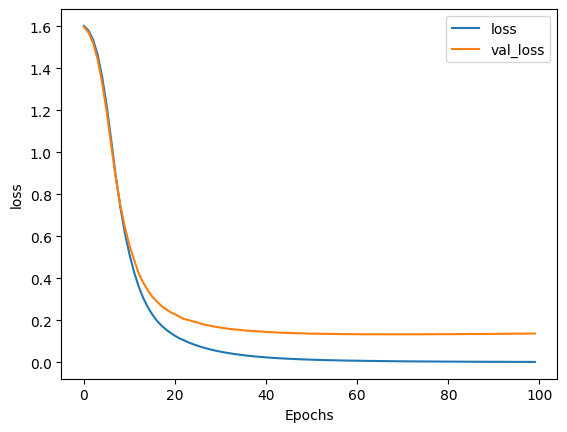

In [45]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [47]:
dif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [89]:
import random

def predict_random_text(test_data, model, tokenizer):
    # Choose a random index from the test data
    random_index = random.randint(0, len(test_data) - 1)
    
    # Get the text at the chosen index
    random_text = test_data.iloc[random_index]['Text']
    
    # Tokenize and pad the text
    tokenized_text = tokenizer.texts_to_sequences([random_text])
    padded_text = pad_sequences(tokenized_text, maxlen=MAXLEN, padding=PADDING)
    
    # Make a prediction
    prediction = model.predict(padded_text)
    predicted_category_index = np.argmax(prediction)
    print(f"index Text: {predicted_category_index}")

    # Convert the index to a category label
    categories = ['sport', 'business', 'politics', 'entertainment', 'tech']
    predicted_category = categories[predicted_category_index]
    
    return random_text, predicted_category

# Example usage
random_text, predicted_category = predict_random_text(dif, model, tokenizer)
print(f"Random Text: {random_text}")

print(f"Predicted Category: {predicted_category}")


1/1 [==============================] - 0s 22ms/step
index Text: 1
Random Text: virgin blue shares plummet 20% shares in australian budget airline virgin blue plunged 20% after it warned of a steep fall in full year profits.  virgin blue said profits after tax for the year to march would be between 10% to 15% lower than the previous year.  sluggish demand reported previously for november and now december 2004 continues   said virgin blue chief executive brett godfrey. virgin blue  which is 25% owned by richard branson  has been struggling to fend off pressure from rival jetstar. it cut its full year passenger number forecast by  approximately 2.5% . virgin blue reported a 22% fall in first quarter profits in august 2004 due to tough competition. in november  first half profits were down due to slack demand and rising fuel costs. virgin blue was launched four years ago and now has roughly one third of australia s domestic airline market. but the national carrier  qantas  has fought back 